In [1]:
import sys
sys.path.append('..')
from dataset import ModisDataset, Sentinel5Dataset
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from model import Model, snapshot, restore
import ignite.metrics
import pandas as pd
from train import train_epoch, test_epoch, test_model, fine_tune
from visualizations import make_and_plot_predictions, predict_future
from dataset import transform_data
from copy import deepcopy

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

num_layers = 1
hidden_size = 128
region = "germany"
epochs = 3
include_time = True

model_dir="/data2/igarss2020/models/"
log_dir = "/data2/igarss2020/models/"
name_pattern = "LSTM_{region}_l={num_layers}_h={hidden_size}_e={epoch}"
log_pattern = "LSTM_{region}_l={num_layers}_h={hidden_size}"

# Plotting
idx = 12
N_seen_points = 230#455
N_predictions = 2

def criterion(y_pred, y_data, log_variances):
    norm = (y_pred-y_data)**2
    loss = (torch.exp(-log_variances) * norm).mean()
    regularization = log_variances.mean()
    return 0.5 * (loss + regularization)

def setup(smooth, smooth_method="mean"):
    model = Model(input_size=1 if not include_time else 2,
                  hidden_size=hidden_size,
                  num_layers=num_layers,
                  output_size=1,
                  device=device,
                  use_attention=True)

    #model.load_state_dict(torch.load("/tmp/model_epoch_0.pth")["model"])
    model.train()

    enddate = '2010-01-01'

    dataset = ModisDataset(region=region,
                           fold="train",
                           znormalize=True,
                           augment=False,
                           overwrite=False,
                           include_time=include_time,
                           filter_date=(None,enddate),
                           smooth=smooth,
                           smooth_method=smooth_method)

    testdataset = ModisDataset(region=region,
                           fold="test",
                           znormalize=True,
                           augment=False,
                           overwrite=False,
                           include_time=include_time,
                           filter_date=(None,None),
                           smooth=smooth,
                           smooth_method=smooth_method)

    validdataset = ModisDataset(region=region,
                                fold="validate",
                                znormalize=True,
                                augment=False,
                                include_time=include_time,
                                smooth=smooth,
                                smooth_method=smooth_method)

    #dataset = Sentinel5Dataset(fold="train", seq_length=300)
    #validdataset = Sentinel5Dataset(fold="validate", seq_length=300)

    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=512,
                                             shuffle=True,
                                             #sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(10000))
                                             )
    validdataloader = torch.utils.data.DataLoader(validdataset,
                                             batch_size=512,
                                             shuffle=False,
                                             #sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(10000))
                                             )

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

    return model, dataset, testdataset, validdataset, dataloader, validdataloader, optimizer

../train.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
train_uptodate=2010-01-01 provided. removing all observations before 2010-01-01
local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz



epoch 0: train loss 0.19, test loss 0.17, mae=0.59, mse=0.57, rmse=0.75
saving model snapshot to /data2/igarss2020/models/LSTM_germany_l=1_h=128_e=0.pth



epoch 1: train loss 0.16, test loss 0.16, mae=0.58, mse=0.56, rmse=0.75
saving model snapshot to /data2/igarss2020/models/LSTM_germany_l=1_h=128_e=1.pth



epoch 2: train loss 0.13, test loss 0.14, mae=0.58, mse=0.55, rmse=0.74
saving model snapshot to /data2/igarss2020/models/LSTM_germany_l=1_h=128_e=2.pth


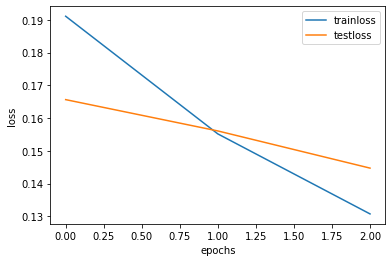

In [2]:
model, dataset, testdataset, validdataset, dataloader, validdataloader, optimizer = setup(None)
if True:
    stats=list()
    for epoch in range(epochs):
        trainloss = train_epoch(model,dataloader,optimizer, criterion, device)
        testmetrics, testloss = test_epoch(model,validdataloader,device, criterion, n_predictions=1)
        metric_msg = ", ".join([f"{name}={metric.compute():.2f}" for name, metric in testmetrics.items()])
        msg = f"epoch {epoch}: train loss {trainloss:.2f}, test loss {testloss:.2f}, {metric_msg}"
        print(msg)

        #test_model(model, validdataset, device)

        model_name = name_pattern.format(region=region, num_layers=num_layers, hidden_size=hidden_size, epoch=epoch)
        pth = os.path.join(model_dir, model_name+".pth")
        print(f"saving model snapshot to {pth}")
        snapshot(model, optimizer, pth)
        stat = dict()
        stat["epoch"] = epoch
        for name, metric in testmetrics.items():
            stat[name]=metric.compute()

        stat["trainloss"] = trainloss.cpu().detach().numpy()
        stat["testloss"] = testloss.cpu().detach().numpy()
        stats.append(stat)

    df = pd.DataFrame(stats)

    fig,ax = plt.subplots()
    ax.plot(df.epoch, df.trainloss, label="trainloss")
    ax.plot(df.epoch, df.testloss, label="testloss")
    ax.legend()
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
else:
    from dataset import download_url
    #url="https://syncandshare.lrz.de/download/MkxBRzlaTGJqS0J4RktaajN3djJB/model_weights/canada/LSTM_canada_l%3D3_h%3D32_e%3D9.pth"
    #download_url(url,"/tmp/model.pth")
    #restore("/data2/igarss2020/models/LSTM_canada_l=3_h=32_e=9.pth",model)
    restore("/data2/igarss2020/models/LSTM_germany_l=3_h=32_e=9.pth",model)
    
    

(<Figure size 1008x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f2576cb38>,
       dtype=object))

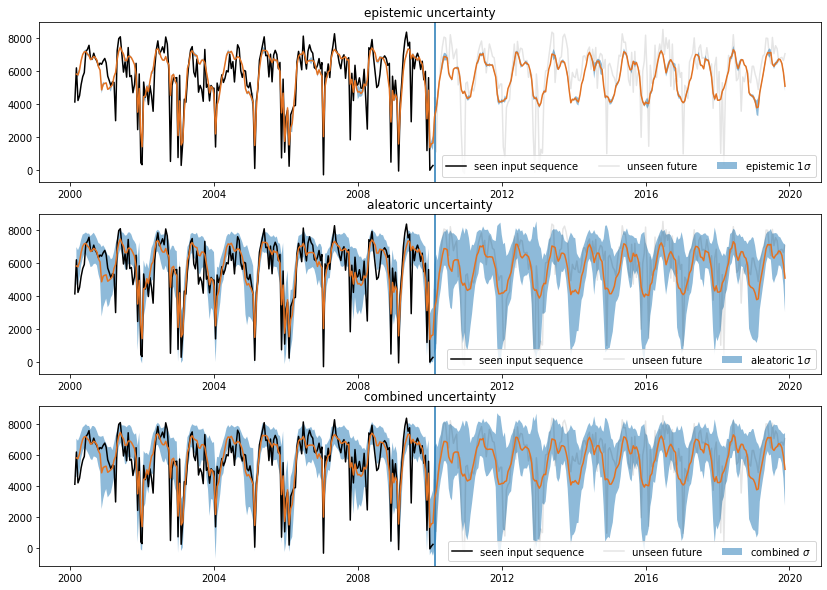

In [3]:
x = testdataset.data[idx].astype(float)
date = testdataset.date[idx].astype(np.datetime64)
store=None
make_and_plot_predictions(model, x, date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                              device=device,meanstd=(dataset.mean,dataset.std), store=store)

In [4]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import torch
import pandas as pd

BANDS = ['B1', 'B10', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8',
       'B8A', 'B9']

sns.set_style("white")
sns.despine(left=True,offset=10, trim=True)

tumorange=(0.89019608, 0.44705882, 0.13333333, 1)
tumblue=(0., 0.39607843, 0.74117647,1)
tumred=(0.76862745,  0.28235294,  0.10588235,1)
tumblack=(0,0,0,1)

def save_plot(fig,fname):
    from matplotlib.backends.backend_pdf import PdfPages
    print(f"writing {fname}")
    with PdfPages(fname) as pdf:
        pdf.savefig(fig,bbox_inches='tight')

fld="/tmp"

def attn_plots(ax, arr, mode="conn"):
    assert mode in ["conn","adj"]
    
    if mode =="adj":
        ax.imshow(arr)
        ax.axis('off')
        ax.set_xlabel("out")
        ax.set_ylabel("in")
    
    elif mode=="conn":
        N = arr.shape[1]
        
        ax.set_xlim(0,N)
        for o in tqdm(range(N)):
            for i in range(N):
                ax.add_line(Line2D([i,o], [0,1],color=(tumred[0],tumred[1],tumred[2],arr[o,i,0]*.5)))
                #ax.add_line(Line2D([i,o], [0,1],color=(tumorange[0],tumorange[1],tumorange[2],arr[o,i,1]*.5)))
                #ax.add_line(Line2D([i,o], [0,1],color=(tumblack[0],tumblack[1],tumblack[2],arr[o,i,2]*.5)))
        ax.axis('off')
    return ax

def future_attention_hook(module, inp, out):
    print(name)
    
    enc_output, enc_slf_attn = out
    
    # Query, Key, Values <- all the same input for self-attention
    query, key, values = inp
    
    print(query.shape)
    print(key.shape)
    print(values.shape)
    
def attention_hook(module, inp, out, name):
    print(name)
    
    enc_output, enc_slf_attn = out
    
    # Query, Key, Values <- all the same input for self-attention
    enc_input, enc_input, enc_input = inp
    
    os.makedirs(os.path.join(fld,name),exist_ok=True)
    
    for i in range(enc_slf_attn.shape[0]):
        np.savetxt(os.path.join(fld,name)+"/enc_slf_attn_{}.txt".format(i), enc_slf_attn[i].cpu().detach().numpy(), fmt="%.4f")
        print("writing "+os.path.join(fld,name)+"/enc_slf_attn_{}.txt".format(i))
    np.savetxt(os.path.join(fld,name)+"/enc_output.txt", enc_output[0].cpu().detach().numpy(), fmt="%.4f")
    print("writing "+os.path.join(fld,name)+"/enc_output.txt")
    np.savetxt(os.path.join(fld,name)+"/enc_input.txt", enc_output[0].cpu().detach().numpy(), fmt="%.4f")
    print("writing "+os.path.join(fld,name)+"/enc_input.txt")
    
    fig,axs = plt.subplots(3,figsize=(12,6))
    axs[0].plot(enc_input[0].cpu().detach().numpy())
    axs[0].set_title("input")
    
    axs[1] = attn_plots(axs[1], enc_slf_attn.transpose(2,0).cpu().detach().numpy(), mode="conn")
    
    axs[1].set_title("attention scores")
    axs[2].set_title("output")
    axs[2].plot(enc_output[0].cpu().detach().numpy())
    
    save_plot(fig,os.path.join(os.path.join(fld,name),name+".pdf"))
    
    #fig.savefig(os.path.join(os.path.join(fld,name),name+".png"), bbox_inches='tight', transparent=True)
    #print("writing "+os.path.join(os.path.join(fld,name),name+".png"))
    
def attention1_hook(module, inp, out):
    attention_hook(module, inp, out, name="attention")
    
    
def outlinear_hook(module, inp, out):
    inp = inp[0].cpu().detach().numpy()
    out = out[0].cpu().detach().numpy()
    print(out.shape)
    fig,ax = plt.subplots(1,figsize=(12,3))
    ax.bar(np.arange(out.shape[0]), np.exp(out))
    ax.set_ylabel("Score")
    ax.set_xlabel("Class")
    
    save_plot(fig,os.path.join(fld,"outlinear.png"))
    #fig.savefig(os.path.join(fld,"outlinear.png"), bbox_inches='tight', transparent=True)
    #print("writing "+os.path.join(fld,"outlinear.png"))
    
def inlayernorm_hook(module, inp, out):
    inp = inp[0]
    out = out[0]
    fig,axs = plt.subplots(2,figsize=(12,6))
    axs[0].plot(inp[0].cpu().detach().numpy())
    axs[1].plot(out.cpu().detach().numpy())
    
def pos_ffn_hook(module, inp, out):
    inp = inp[0]
    out = out[0]
    fig,axs = plt.subplots(2,figsize=(12,6))
    axs[0].plot(inp[0].cpu().detach().numpy())
    axs[1].plot(out.cpu().detach().numpy())

<Figure size 432x288 with 0 Axes>

In [5]:
input = torch.Tensor(x)[None, :].to(device)

h_t = torch.zeros(model.num_layers, input.size(0), model.hidden_size, dtype=torch.float32).to(model.device)
c_t = torch.zeros(model.num_layers, input.size(0), model.hidden_size, dtype=torch.float32).to(model.device)

outputs, log_variances, (h_t, c_t), context = model.encode(input, h_t, c_t)

handle = model.attention.register_forward_hook(future_attention_hook)

future_outputs, future_logvariances = model.decode(outputs, h_t, c_t, future=1,y=None, date=None, context=context)

handle.remove()

RuntimeError: size mismatch, m1: [1 x 1], m2: [2 x 128] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:273

In [20]:
handle.remove()

  0%|          | 0/230 [00:00<?, ?it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt


100%|██████████| 230/230 [00:19<00:00, 11.57it/s]


writing /tmp/self-attention-1/self-attention-1.pdf


100%|██████████| 1/1 [00:00<00:00, 1447.31it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



100%|██████████| 1/1 [00:00<00:00, 2159.79it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



100%|██████████| 1/1 [00:00<00:00, 1305.82it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



100%|██████████| 1/1 [00:00<00:00, 1689.89it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



100%|██████████| 1/1 [00:00<00:00, 298.95it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



100%|██████████| 1/1 [00:00<00:00, 1790.14it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



100%|██████████| 1/1 [00:00<00:00, 1567.96it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



100%|██████████| 1/1 [00:00<00:00, 1364.45it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



100%|██████████| 1/1 [00:00<00:00, 1407.01it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



100%|██████████| 1/1 [00:00<00:00, 1474.27it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



100%|██████████| 1/1 [00:00<00:00, 1600.88it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



100%|██████████| 1/1 [00:00<00:00, 1581.56it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



100%|██████████| 1/1 [00:00<00:00, 1397.64it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



100%|██████████| 1/1 [00:00<00:00, 1162.18it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



100%|██████████| 1/1 [00:00<00:00, 1340.03it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



100%|██████████| 1/1 [00:00<00:00, 1771.24it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



100%|██████████| 1/1 [00:00<00:00, 1406.54it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



100%|██████████| 1/1 [00:00<00:00, 542.11it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 2024.28it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 389.88it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 1612.57it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 1512.01it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 1530.21it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 1973.79it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 631.48it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 594.68it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 2064.13it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 1616.30it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 2102.41it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 1290.56it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 514.13it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 1555.17it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 954.55it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 1760.83it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 1597.22it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 1411.27it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 1858.35it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 579.16it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 1187.85it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 1349.08it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 1572.67it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 594.09it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 1703.62it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf


self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt


/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 1776.49it/s]


writing /tmp/self-attention-1/self-attention-1.pdf


/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 2076.39it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 1481.04it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf



/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
100%|██████████| 1/1 [00:00<00:00, 701.27it/s]

self-attention-1
writing /tmp/self-attention-1/enc_slf_attn_0.txt
writing /tmp/self-attention-1/enc_output.txt
writing /tmp/self-attention-1/enc_input.txt
writing /tmp/self-attention-1/self-attention-1.pdf


KeyboardInterrupt: 

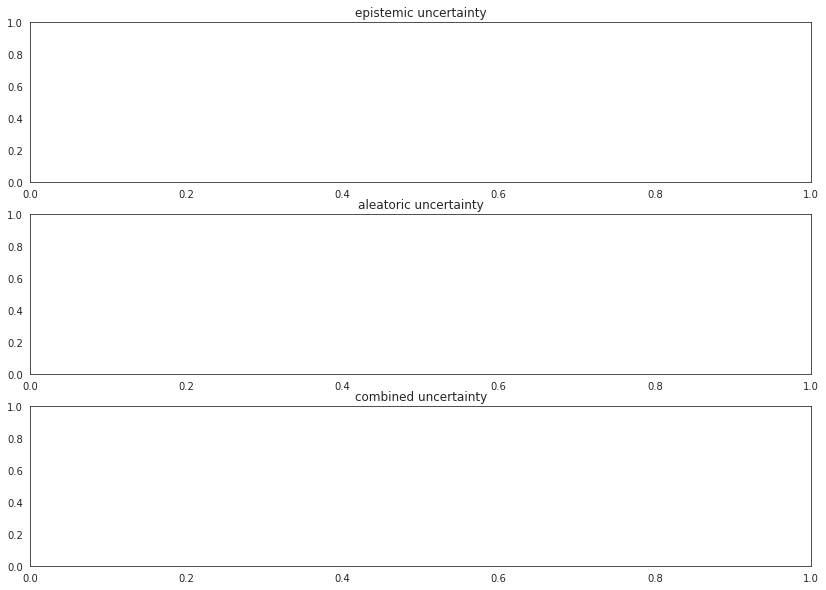

Error in callback <function flush_figures at 0x7fd8ce9a9a60> (for post_execute):


KeyboardInterrupt: 

In [7]:
x = testdataset.data[idx].astype(float)
date = testdataset.date[idx].astype(np.datetime64)
store=None
make_and_plot_predictions(model, x, date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                              device=device,meanstd=(dataset.mean,dataset.std), store=store)

In [12]:
handle.remove()

In [8]:
N_predictions

2

In [9]:
x

array([[-6.83346777e-01,  7.35417023e-01],
       [ 2.23832984e-01,  8.91981346e-01],
       [-6.44817907e-01,  9.81306470e-01],
       [-5.16096455e-01,  9.96658902e-01],
       [-2.18811195e-01,  9.36881346e-01],
       [-1.12806898e-02,  8.06479946e-01],
       [ 9.86141558e-02,  6.15284600e-01],
       [ 6.56844945e-01,  3.77707965e-01],
       [ 7.16389563e-01,  1.11659007e-01],
       [ 8.24970924e-01, -1.62807013e-01],
       [ 4.68578875e-01, -4.25000340e-01],
       [ 4.59822314e-01, -6.55156357e-01],
       [ 6.14375622e-01, -8.35925479e-01],
       [ 4.79086749e-01, -9.53680997e-01],
       [ 4.02904665e-01, -9.99546281e-01],
       [ 2.78999321e-01, -9.70063922e-01],
       [ 3.50365296e-01, -8.67456355e-01],
       [ 3.19717331e-01, -6.99458327e-01],
       [ 4.11661226e-01, -4.78733840e-01],
       [ 4.74708468e-01, -2.21921513e-01],
       [ 3.59997514e-01,  0.00000000e+00],
       [ 4.48112072e-03,  2.71958158e-01],
       [-1.17672911e-01,  5.23415607e-01],
       [-2.